<a href="https://colab.research.google.com/github/rkarpin/ML_LAB/blob/main/ML_homework_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [141]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


Będę pracować z danymi dotyczącymi raka piersi, na podstawie danych medycznych będę chciał przewidzieć czy pacjent jest chory.

In [142]:

data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df["target"] = data.target



In [143]:
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [144]:
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=1, stratify=df["target"])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=1, stratify=temp_df["target"])

X_train, y_train = train_df.drop(columns=["target"]), train_df["target"]
X_val, y_val = val_df.drop(columns=["target"]), val_df["target"]
X_test, y_test = test_df.drop(columns=["target"]), test_df["target"]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [145]:
model = LogisticRegression(max_iter=1000, random_state=1)
model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=1)

In [146]:
y_val_probs = model.predict_proba(X_val_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_val_probs,drop_intermediate=False)
roc_auc = auc(fpr, tpr)

Wykrywam chorobę, więc bardzo chcę uniknąć wyników fałszywie negatywnych (bo to groźne),
czyli ważny jest True Positive Rate (1 - False Negative Rate), a False Positive Rate jest trochę mniej ważny,
 ale też chcę uniknąć tego, że zdrowemu pacjentowi błędnie przypisuje się chorobę.

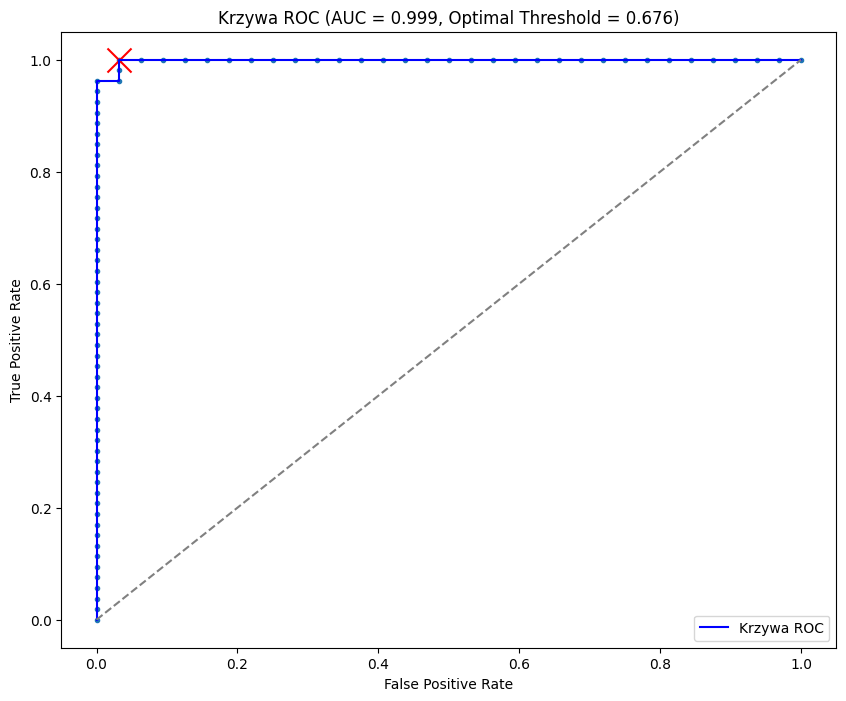

In [147]:


best = np.argmin(fpr-5*tpr)

plt.figure(figsize=(10, 8))

plt.plot(fpr, tpr, color="blue", label=f"Krzywa ROC")
plt.scatter(fpr, tpr,marker='.')
plt.scatter(fpr[best], tpr[best], color='red',marker='x',s=300)
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")


plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"Krzywa ROC (AUC = {round(roc_auc,3)}, Optimal Threshold = {round(thresholds[best],3)})")
plt.legend(loc="lower right")


plt.show()

In [148]:
y_test_probs = model.predict_proba(X_test_scaled)[:, 1]
y_test_pred_new = (y_test_probs >= thresholds[best]).astype(int)

print("Accuracy score:",accuracy_score(y_test, y_test_pred_new))
print("Precision score:",precision_score(y_test, y_test_pred_new))
print("Recall score:",recall_score(y_test, y_test_pred_new))
print("F1 score:",f1_score(y_test, y_test_pred_new))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_test_pred_new)[0])
print(confusion_matrix(y_test, y_test_pred_new)[1])

Accuracy score: 0.9534883720930233
Precision score: 0.9629629629629629
Recall score: 0.9629629629629629
F1 score: 0.9629629629629629
Confusion matrix:
[30  2]
[ 2 52]


1. **Would a different threshold yield better results?** **How does shifting the threshold affect the trade-off between sensitivity and specificity?**

  Zmiana thresholdu przesuwa nas po krzywej ROC (tak jak na wykresie).
   Sensitivity to oś pionowa, specificity to 1-FPR, a FPR to oś pozioma.
Niski treshold daje małe specificity i duże sensitivity, a wysoki treshold daje duże specificity i małe sensitivity. Wybieramy taki threshold, aby specificity i sensitivity były jak najlepiej dopasowane do naszych potrzeb.

2. **How do you define "better" results? Is higher specificity more valuable than higher sensitivity in certain contexts? Or maybe the other way around? Does the best threshold depend on the task? (discuss cases like disease detection vs. spam filtering)**

  Wykrywam chorobę, więc bardzo chcę uniknąć wyników fałszywie negatywnych (bo to groźne), czyli ważny jest True Positive Rate (1 - False Negative Rate), a False Positive Rate jest trochę mniej ważny, ale też chcę uniknąć tego, że zdrowemu pacjentowi błędnie przypisuje się chorobę.

  Gdybym zajmował się wykrywaniem spamu, to byłoby na odwrót, bo bardzo chcę uniknąć sytuacji gdzie zwykły email wpadnie do spamu, czyli chcę przede wszystkim minimalizować False Positive Rate, ale oczywiście muszę coś odfiltrować, więc True Positive Rate też jest ważne.

3. **How does a ROC curve help in this process?**

  Krzywa ROC pozwala zwizualizować zależność między True Positive Rate a False Positive Rate w zależności od tresholdu.

4. **How do you select the optimal threshold using the ROC curve?**

  Można sobie wyobrazić wiele sposobów na wybranie odpowiedniego thresholdu. W moim przypadku wybieram taki treshold, który minimalizuje wartość FPR-5*TPR, czyli przyjmuję że TPR jest 5 razy ważniejszy niż FPR. W pytaniu 2 odpowiedziałem, czemu w moim przypadku TPR jest ważniejsze.

5. **What is the AUC metric and how is it useful?**

  AUC to pole pod wykresem ROC. Im większe AUC tym lepszy model.
